# Test U-Net

## Imports

In [2]:
import os
import random


import cv2 as cv
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, callbacks, losses
from tensorflow.keras.applications import EfficientNetB4
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import sys
sys.path.append('code')
from eval_functions import calculate_score
from Loss_Metrics import jaccard_coef, jaccard_coef_loss, dice_coef_loss
sys.path.append('../')

## Preparing test data

In [3]:
# Finding the number of images in each dataset
test_path = os.path.normpath('dataset/MapAI/512x512_task1_test/image')
no_test_images = len([name for name in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, name))])

# Defining size of images
IMG_HEIGHT = 512
IMG_WIDTH = 512

# Creating NumPy arrays for the different subsets
X_test = np.zeros((no_test_images, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
Y_test = np.zeros((no_test_images, IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

# Adding images to NumPy arrays
img_path = os.path.normpath('dataset/MapAI/512x512_task1_test/image')
mask_path = os.path.normpath('dataset/MapAI/512x512_task1_test/mask')
#mask_path = os.path.normpath('dataset/MapAI/512x512_task1_test/edge_mask')
with os.scandir(img_path) as entries:
    for n, entry in enumerate(entries):
        img = cv.imread(os.path.normpath(img_path + '/' + entry.name))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        X_test[n] = img
        mask = cv.imread(os.path.normpath(mask_path + '/' + entry.name))
        mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
        Y_test[n] = mask

In [4]:
# Print the size of the different sets
print('X_train size: ' + str(len(X_test)))
print('Y_train size: ' + str(len(Y_test)))

X_train size: 1368
Y_train size: 1368


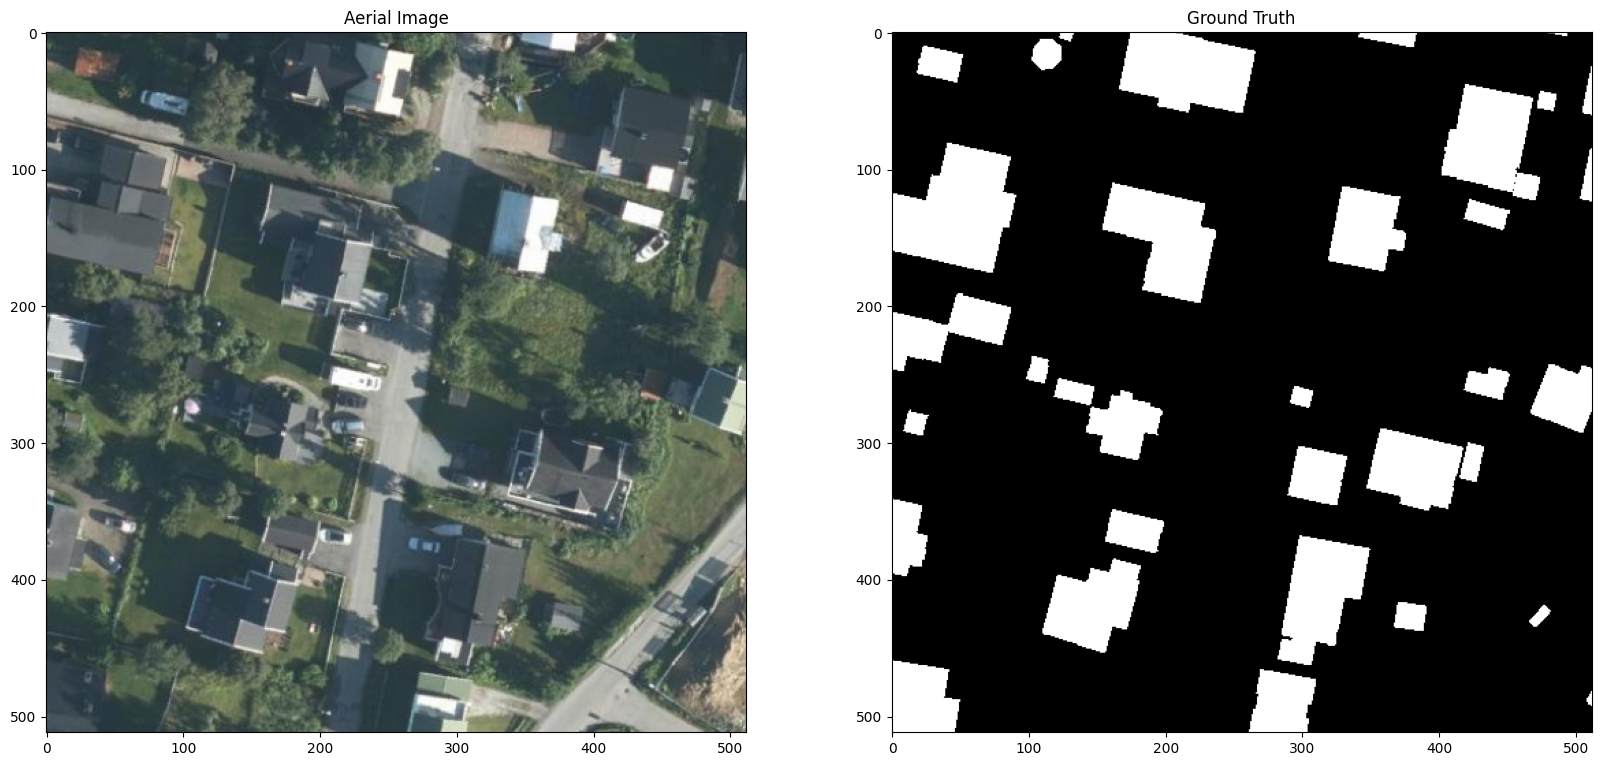

(array([0, 1], dtype=uint8), array([212855,  49289], dtype=int64))


In [7]:
# Display a random image from test set
index = random.randint(0, no_test_images)

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title('Aerial Image')
plt.imshow(X_test[index])
plt.subplot(222)
plt.title('Ground Truth')
plt.imshow(Y_test[index], cmap='gray')
plt.show()

print(np.unique(Y_test[index], return_counts=True))

## Testing model

In [8]:
# Load model
model_name = 'effnet_ctunet_dice_datagen'
model = models.load_model(os.path.normpath('models/' + model_name), custom_objects={'dice_coef_loss': dice_coef_loss, 'jaccard_coef': jaccard_coef})

In [9]:
Y_pred = model.predict(X_test)

43/43 [==============================] - 7409s 171s/step


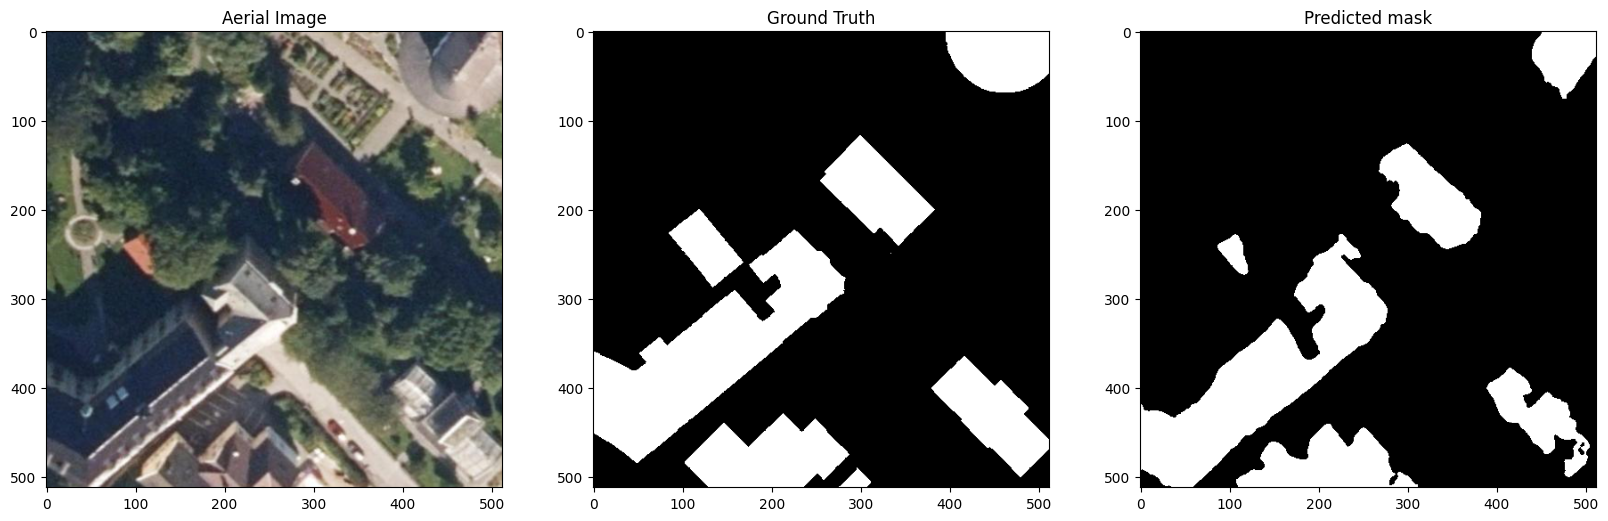

(array([0, 1], dtype=uint8), array([199341,  62803], dtype=int64))
(array([False,  True]), array([211644,  50500], dtype=int64))


In [90]:
# Display predicted image mask

index = random.randint(0, no_test_images)

plt.figure(figsize=(20,20))
plt.subplot(231)
plt.title('Aerial Image')
plt.imshow(X_test[index])
plt.subplot(232)
plt.title('Ground Truth')
plt.imshow(Y_test[index], cmap='gray')
plt.subplot(233)
plt.title('Predicted mask')
plt.imshow((Y_pred > 0.5)[index], cmap='gray')
plt.show()

print(np.unique(Y_test[index], return_counts=True))
print(np.unique((Y_pred > 0.5)[index], return_counts=True))

## Evaluating model

In [10]:
score = calculate_score(np.squeeze((Y_pred > 0.5), -1).astype(np.uint8), Y_test)
print(score)

{'score': 0.6934297656667712, 'iou': 0.7812553803337285, 'biou': 0.6056041509998139}


In [95]:
Y_pred_test = np.squeeze((Y_pred > 0.5), -1).astype(np.uint8)

## Time Test Augmentation

In [110]:
Y_pred_tta = []
for image in tqdm(X_test):
    prediction_original = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]

    prediction_lr = model.predict(np.expand_dims(np.fliplr(image), axis=0), verbose=0)[0]
    prediction_lr = np.fliplr(prediction_lr)

    prediction_ud = model.predict(np.expand_dims(np.flipud(image), axis=0), verbose=0)[0]
    prediction_ud = np.flipud(prediction_ud)

    prediction_lr_ud = model.predict(np.expand_dims(np.fliplr(np.flipud(image)), axis=0), verbose=0)[0]
    prediction_lr_ud = np.fliplr(np.flipud(prediction_lr_ud))

    predicition = (prediction_original + prediction_lr + prediction_ud + prediction_lr_ud) / 4
    Y_pred_tta.append(predicition)

100%|███████████████████████████████████████████████████████████████████████████| 1368/1368 [10:11:33<00:00, 26.82s/it]


In [114]:
Y_pred_tta_arr = np.array(Y_pred_tta)

In [176]:
print('Model score')
score = calculate_score(np.squeeze((Y_pred > 0.5), -1).astype(np.uint8), Y_test)
print(score)

print('Test Time Augmentation')
print('Threshold 0.3')
score = calculate_score(np.squeeze((Y_pred_tta_arr > 0.3), -1).astype(np.uint8), Y_test)
print(score)

print('Threshold 0.4')
score = calculate_score(np.squeeze((Y_pred_tta_arr > 0.4), -1).astype(np.uint8), Y_test)
print(score)

print('Threshold 0.5')
score = calculate_score(np.squeeze((Y_pred_tta_arr > 0.5), -1).astype(np.uint8), Y_test)
print(score)

Model score
{'score': 0.6934297656667712, 'iou': 0.7812553803337285, 'biou': 0.6056041509998139}
Test Time Augmentation
Threshold 0.3
{'score': 0.7003638952608919, 'iou': 0.7883352140547759, 'biou': 0.6123925764670081}
Threshold 0.4
{'score': 0.7001497605255151, 'iou': 0.7880783753271983, 'biou': 0.6122211457238321}
Threshold 0.5
{'score': 0.6992219400062553, 'iou': 0.7869376819354075, 'biou': 0.611506198077103}


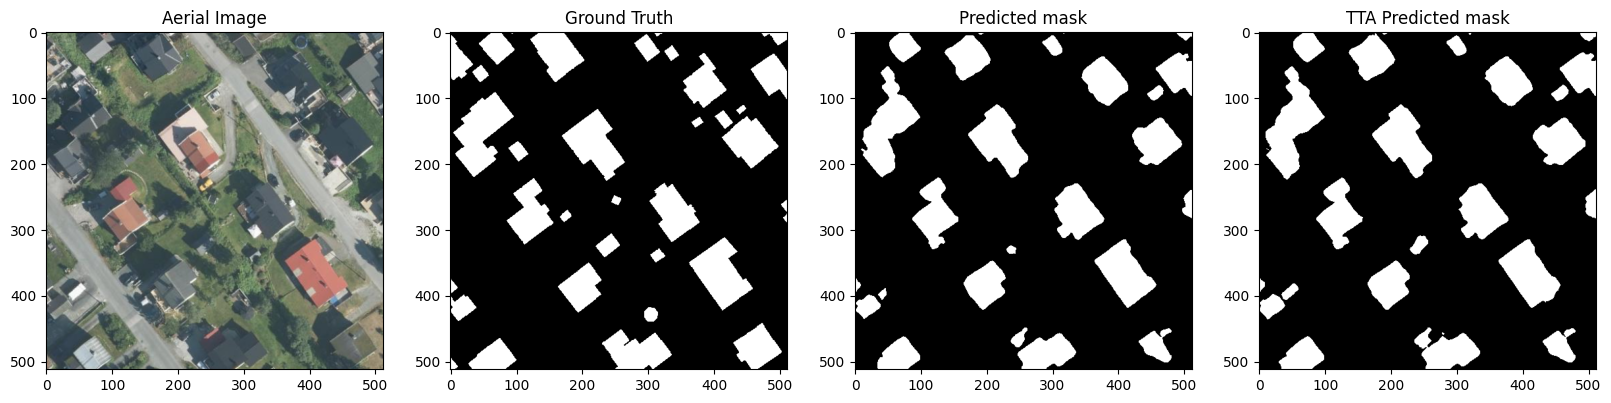

In [230]:
# Display predicted image mask

index = random.randint(0, no_test_images)

plt.figure(figsize=(20,20))
plt.subplot(141)
plt.title('Aerial Image')
plt.imshow(X_test[index])
plt.subplot(142)
plt.title('Ground Truth')
plt.imshow(Y_test[index], cmap='gray')
plt.subplot(143)
plt.title('Predicted mask')
plt.imshow((Y_pred > 0.5)[index], cmap='gray')
plt.subplot(144)
plt.title('TTA Predicted mask')
plt.imshow((Y_pred_tta_arr > 0.3)[index], cmap='gray')
plt.show()


## Morphological filters

In [216]:
morphed_img_list = []
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(9,9))
for img in tqdm(Y_pred_tta_arr):
    image = (img > 0.3).astype(np.uint8)
    #morph = cv.morphologyEx(image, cv.MORPH_OPEN, kernel)
    morph = cv.morphologyEx(image, cv.MORPH_CLOSE, kernel)
    morphed_img_list.append(morph)

morphed_img_list = np.array(morphed_img_list)

100%|█████████████████████████████████████████████████████████████████████████████| 1368/1368 [00:01<00:00, 946.19it/s]


In [200]:
score = calculate_score(morphed_img_list, Y_test)
print(score)

{'score': 0.7005173610478894, 'iou': 0.788944476894068, 'biou': 0.6120902452017108}
